# Предобработка данных: выявление выбросов в данных

## Содержание

1. [Распределения данных](#1-распределения-данных)
2. [Визуализация распределений](#2-визуализация-распределений)
3. [Что такое выбросы?](#3-что-такое-выбросы)
4. [Методы выявления выбросов](#4-методы-выявления-выбросов)
    - Визуальный метод
    - Метод межквартильного размаха (IQR)
    - Метод Z-оценки (Z-score)
5. [Сравнение методов](#5-сравнение-методов)
6. [Практические рекомендации](#6-практические-рекомендации)


In [1]:
# Импорт необходимых библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Настройка стиля графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

---

# 1. Распределения данных

Прежде чем анализировать выбросы, важно понять характер распределения данных.

**Распределение данных** описывает частоту появления различных значений в наборе данных и определяет, какие методы анализа будут наиболее эффективны.

## 1.1. Основные типы распределений

Распределения можно классифицировать по различным критериям. В контексте анализа выбросов наиболее 
важной является **классификация по форме распределения (симметрии)**, которая определяет подход 
к обнаружению аномалий. По этому критерию выделяют три основных типа:

### Симметричное (нормальное) распределение
- **Характеристики:** Среднее значение ≈ Медиана ≈ Мода  
- **Коэффициент асимметрии (skewness):** близок к 0 (|skew| < 0.5)  
- **Форма:** Характерная "колоколообразная" кривая  
- **Примеры:** Рост взрослых людей, показатели IQ, случайные ошибки измерений  

### Правостороннее асимметричное распределение (положительная асимметрия)
- **Характеристики:** Среднее > Медиана > Мода  
- **Коэффициент асимметрии:** > 0 (положительный)  
- **Форма:** Длинный "хвост" в правой части распределения  
- **Примеры:** Уровень доходов населения, цены на недвижимость, время отклика сервера  

### Левостороннее асимметричное распределение (отрицательная асимметрия)
- **Характеристики:** Среднее < Медиана < Мода  
- **Коэффициент асимметрии:** < 0 (отрицательный)  
- **Форма:** Длинный "хвост" в левой части распределения  
- **Примеры:** Оценки на экзаменах, возраст смерти в развитых странах, результаты тестов с "потолком" сложности

---

**Примечание о других классификациях:** Помимо симметрии, распределения также различают по **типу данных** 
(дискретные и непрерывные) и по **форме** (унимодальные, бимодальные, равномерные). Каждый тип требует 
специфического подхода к анализу выбросов, но симметрия является ключевым фактором при выборе пороговых 
значений для методов обнаружения аномалий.

### 📐 Коэффициент асимметрии (Skewness)

**Skewness** — это статистическая мера, характеризующая асимметричность распределения данных относительно среднего значения.

| Значение Skewness | Интерпретация | Тип распределения |
|-------------------|---------------|-------------------|
| < -1 | Сильная отрицательная асимметрия | Левостороннее |
| -1 до -0.5 | Умеренная отрицательная асимметрия | Левостороннее |
| -0.5 до 0 | Слабая отрицательная асимметрия | Приблизительно симметричное |
| 0 | Идеальная симметрия | Симметричное |
| 0 до 0.5 | Слабая положительная асимметрия | Приблизительно симметричное |
| 0.5 до 1 | Умеренная положительная асимметрия | Правостороннее |
| > 1 | Сильная положительная асимметрия | Правостороннее |

**Примечание**: В различных источниках границы интервалов могут незначительно отличаться, но представленная классификация является наиболее распространенной в статистической практике.

## Генерация примеров разных типов распределений

In [2]:
from numpy.random import default_rng

# Создание генератора с seed для воспроизводимости
rng = default_rng(42)

In [3]:
# 1. Симметричное (нормальное) распределение
symmetric_data = rng.normal(loc=100, scale=15, size=1000) # Нормальное распределение с параметрами Среднее=100, Стандартное отклонение=15

In [4]:
# 2. Правостороннее асимметричное распределение (экспоненциальное)
right_skewed_data = rng.exponential(scale=2, size=1000) * 30 + 50 # Сдвиг данных вправо для положительных значений

In [5]:
# 3. Левостороннее асимметричное распределение (отраженное экспоненциальное)
left_skewed_data = 100 - rng.exponential(scale=2, size=1000) * 30 # Сдвиг данных влево для отрицательных значений

In [6]:
print("=" * 70)
print("СТАТИСТИКИ РАСПРЕДЕЛЕНИЙ")
print("=" * 70)

# Функция для вывода статистик
def print_distribution_stats(data, name):
    mean = np.mean(data)
    median = np.median(data)
    skewness = stats.skew(data)
    
    print(f"\n{name}:")
    print(f"  Среднее:     {mean:>8.2f}")
    print(f"  Медиана:     {median:>8.2f}")
    print(f"  Разность:    {mean - median:>8.2f}")
    print(f"  Skewness:    {skewness:>8.3f}")
    
    # Более детальная интерпретация skewness
    if abs(skewness) < 0.5:
        symmetry_type = "Приблизительно симметричное"
    elif 0.5 <= abs(skewness) < 1:
        symmetry_type = "Умеренно асимметричное"
    else:
        symmetry_type = "Сильно асимметричное"
    
    if skewness > 0:
        direction = "Правостороннее (среднее > медиана)"
    elif skewness < 0:
        direction = "Левостороннее (среднее < медиана)"
    else:
        direction = "Симметричное (среднее ≈ медиана)"
    
    print(f"  → {symmetry_type}, {direction}")

print_distribution_stats(symmetric_data, "Симметричное распределение")
print_distribution_stats(right_skewed_data, "Правостороннее асимметричное распределение")
print_distribution_stats(left_skewed_data, "Левостороннее асимметричное распределение")

СТАТИСТИКИ РАСПРЕДЕЛЕНИЙ

Симметричное распределение:
  Среднее:        99.57
  Медиана:       100.09
  Разность:       -0.53
  Skewness:      -0.044
  → Приблизительно симметричное, Левостороннее (среднее < медиана)

Правостороннее асимметричное распределение:
  Среднее:       110.93
  Медиана:        93.14
  Разность:       17.80
  Skewness:       2.192
  → Сильно асимметричное, Правостороннее (среднее > медиана)

Левостороннее асимметричное распределение:
  Среднее:        39.93
  Медиана:        56.99
  Разность:      -17.06
  Skewness:      -2.089
  → Сильно асимметричное, Левостороннее (среднее < медиана)


# 2. Визуализация распределений

## 2.1. Гистограмма (Histogram)

**Гистограмма** показывает распределение данных, разбивая диапазон значений на интервалы (bins) и подсчитывая количество наблюдений в каждом интервале.


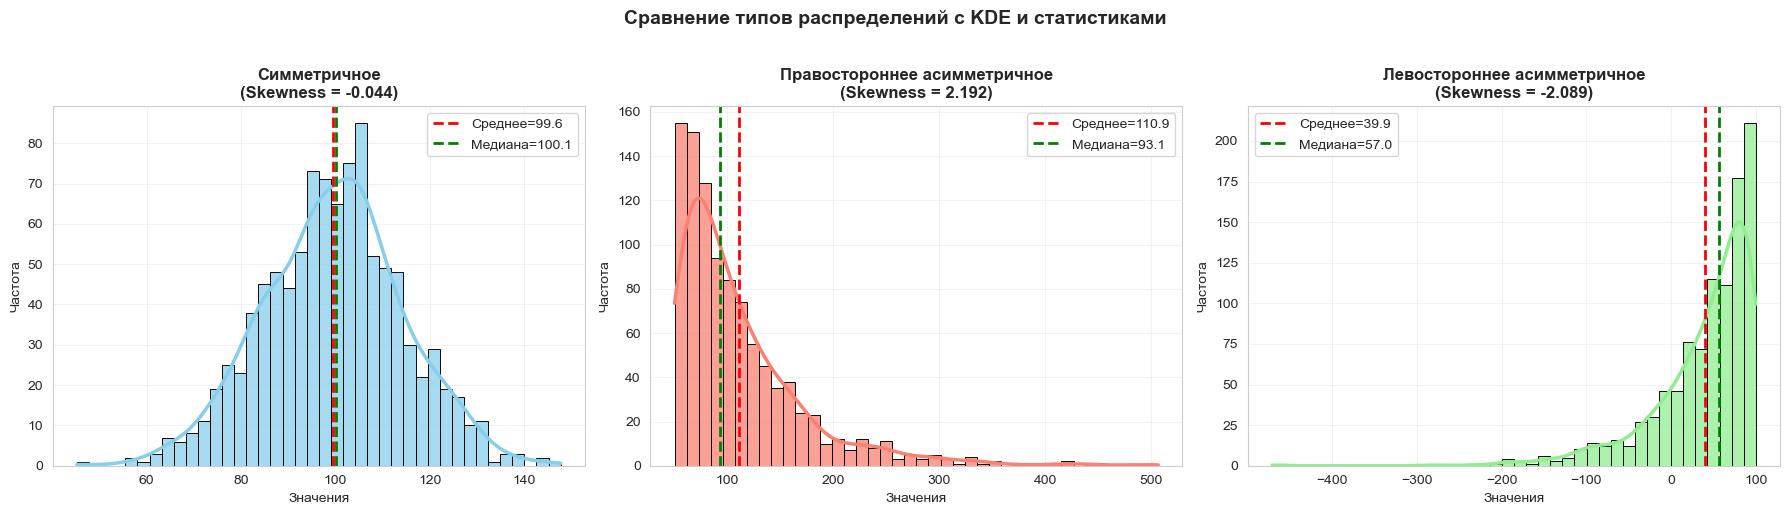

In [ ]:
# Создание гистограмм для трех типов распределений с KDE и отображением статистик
# KDE (Kernel Density Estimation - оценка плотности ядра)

# Создание подграфиков
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Распределения данных и их параметры для графиков
distributions = [
    (symmetric_data, 'Симметричное', 'skyblue', 'darkblue'),
    (right_skewed_data, 'Правостороннее асимметричное', 'salmon', 'darkred'),
    (left_skewed_data, 'Левостороннее асимметричное', 'lightgreen', 'darkgreen')
]

for ax, (data, title, hist_color, kde_color) in zip(axes, distributions):
    mean = np.mean(data)
    median = np.median(data)
    skewness = stats.skew(data)
    
    # Гистограмма с настройкой цвета KDE
    sns.histplot(data, ax=ax, kde=True, color=hist_color, 
                 alpha=0.75, edgecolor='black', bins=40,
                 line_kws={'color': kde_color, 'linewidth': 2.5, 'linestyle': '-'})
    
    # Добавляем линии статистик
    ax.axvline(mean, color='red', linestyle='--', linewidth=2, 
               label=f'Среднее={mean:.1f}')
    ax.axvline(median, color='green', linestyle='--', linewidth=2, 
               label=f'Медиана={median:.1f}')
    
    ax.set_title(f'{title}\n(Skewness = {skewness:.3f})', fontweight='bold', fontsize=12)
    ax.set_xlabel('Значения')
    ax.set_ylabel('Частота')
    ax.legend()
    ax.grid(True, alpha=0.25)

plt.suptitle('Сравнение типов распределений с KDE и статистиками', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

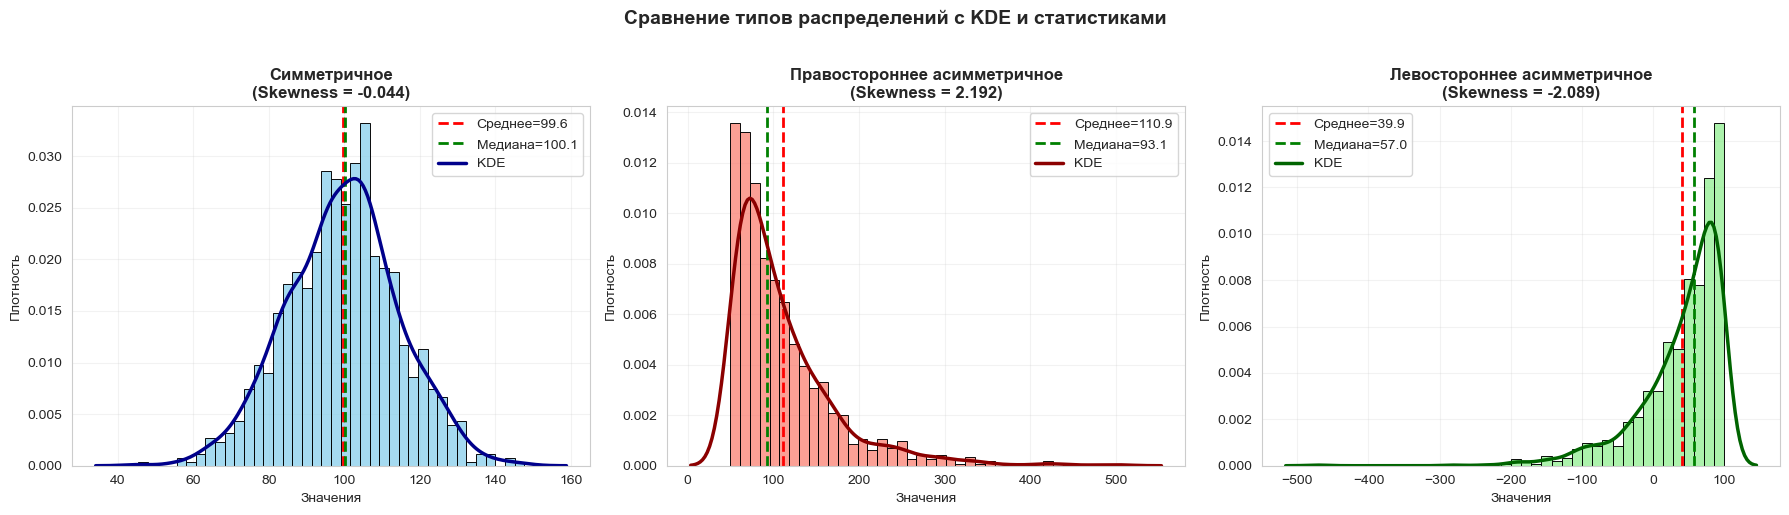

In [ ]:
# Создание гистограмм для трех типов распределений с KDE и отображением статистик
# KDE (Kernel Density Estimation - оценка плотности ядра)

# Создание подграфиков
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Распределения данных и их параметры для графиков
distributions = [
    (symmetric_data, 'Симметричное', 'skyblue', 'darkblue'),
    (right_skewed_data, 'Правостороннее асимметричное', 'salmon', 'darkred'),
    (left_skewed_data, 'Левостороннее асимметричное', 'lightgreen', 'darkgreen')
]

for ax, (data, title, hist_color, kde_color) in zip(axes, distributions):
    mean = np.mean(data)
    median = np.median(data)
    skewness = stats.skew(data)
    
    # Гистограмма без KDE, но с плотностью (density)
    sns.histplot(data, ax=ax, kde=False, color=hist_color, 
                 alpha=0.75, edgecolor='black', bins=40, stat='density')
    
    # Добавляем линии статистик
    ax.axvline(mean, color='red', linestyle='--', linewidth=2, 
               label=f'Среднее={mean:.1f}')
    ax.axvline(median, color='green', linestyle='--', linewidth=2, 
               label=f'Медиана={median:.1f}')
    
    # KDE с темным цветом отдельно
    sns.kdeplot(data, ax=ax, color=kde_color, linewidth=2.5, label='KDE')

    ax.set_title(f'{title}\n(Skewness = {skewness:.3f})', fontweight='bold', fontsize=12)
    ax.set_xlabel('Значения')
    ax.set_ylabel('Плотность')
    ax.legend()
    ax.grid(True, alpha=0.25)

plt.suptitle('Сравнение типов распределений с KDE и статистиками', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 2.2. Коробчатая диаграмма (Boxplot)

**Boxplot (диаграмма размаха)** — это стандартизированный способ отображения распределения данных на основе пяти ключевых значений: минимум, Q1, медиана, Q3, максимум.
 
### Структура Boxplot:

```
    ●  ← выброс (outlier)
    |
    ┬  ← максимум без выбросов (верхний "ус")
    │
   ┌─┐
   │ │ ← Q3 (75% данных ниже этого значения)
   ├─┤ ← медиана (50% данных ниже)
   │ │ ← Q1 (25% данных ниже)
   └─┘
    │
    ┴  ← минимум без выбросов (нижний "ус")
    |
    ●  ← выброс (outlier)
```
 
### Основные компоненты:

- **Q1 (первый квартиль):** 25% данных меньше этого значения
- **Q2 (медиана):** 50% данных меньше этого значения
- **Q3 (третий квартиль):** 75% данных меньше этого значения
- **IQR (межквартильный размах):** Q3 - Q1 (высота коробки)
- **Усы (whiskers):** 
  - Верхний: до максимума в пределах Q3 + 1.5×IQR
  - Нижний: до минимума в пределах Q1 - 1.5×IQR
- **Выбросы:** точки за пределами усов

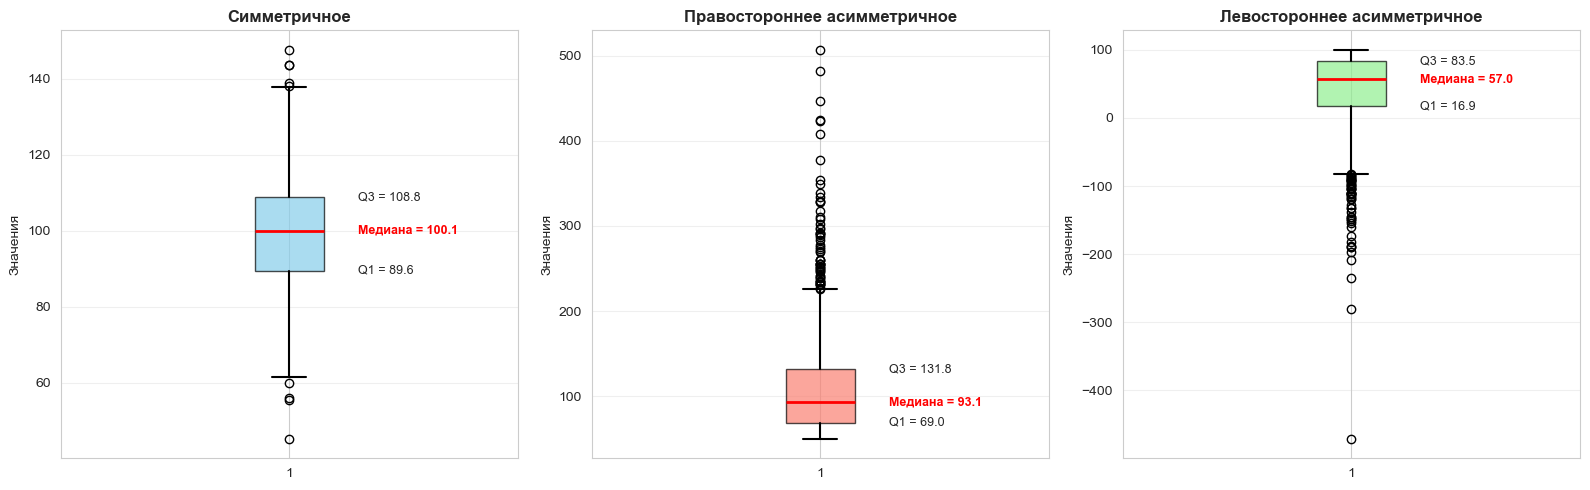

In [33]:
# Создание boxplot для трех типов распределений
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

distributions = [
    (symmetric_data, 'Симметричное', 'skyblue'),
    (right_skewed_data, 'Правостороннее асимметричное', 'salmon'),
    (left_skewed_data, 'Левостороннее асимметричное', 'lightgreen')
]

for ax, (data, title, color) in zip(axes, distributions):
    bp = ax.boxplot(data, vert=True, patch_artist=True,
                    boxprops=dict(facecolor=color, alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    
    # Вычисление квартилей
    Q1 = np.percentile(data, 25)
    Q2 = np.percentile(data, 50)  # медиана
    Q3 = np.percentile(data, 75)
    
    # Добавление текстовых меток
    ax.text(1.15, Q1, f'Q1 = {Q1:.1f}', fontsize=9, va='center')
    ax.text(1.15, Q2, f'Медиана = {Q2:.1f}', fontsize=9, va='center', color='red', fontweight='bold')
    ax.text(1.15, Q3, f'Q3 = {Q3:.1f}', fontsize=9, va='center')
    
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_ylabel('Значения')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 3. Что такое выбросы?

## 3.1. Определение

**Выброс (outlier)** — это наблюдение, которое значительно отличается от других наблюдений в выборке.
Выброс может возникнуть из-за:

1. **Ошибки измерения или ввода данных** ❌
- Неправильно записанное значение
- Неисправность оборудования
- Человеческая ошибка

2. **Естественной вариабельности** ✅
- Редкое, но реальное событие
- Экстремальное, но валидное значение
- Важная информация!

## 3.2. Почему важно выявлять выбросы?

- **Искажают статистики:** среднее, стандартное отклонение
- **Влияют на модели машинного обучения:** особенно линейную регрессию
- **Могут указывать на проблемы:** в процессе сбора данных
- **Требуют внимания:** нужно понять причину


# 3.3. Пример влияния выбросов

In [37]:
# Демонстрация влияния выбросов на статистики
normal_data = [45, 50, 48, 52, 49, 51, 47, 53, 46, 54, 48, 50, 52]
data_with_outlier = normal_data + [200]  # добавляем выброс
print(normal_data)
print(data_with_outlier)

[45, 50, 48, 52, 49, 51, 47, 53, 46, 54, 48, 50, 52]
[45, 50, 48, 52, 49, 51, 47, 53, 46, 54, 48, 50, 52, 200]


In [43]:
print("=" * 70)
print("ВЛИЯНИЕ ВЫБРОСОВ НА СТАТИСТИКИ")
print("=" * 70)

print("\n📊  БЕЗ ВЫБРОСА:")
print(f"   Mean:     {np.mean(normal_data):.2f}")
print(f"   Median:     {np.median(normal_data):.2f}")
print(f"   Std:         {np.std(normal_data):.2f}")

print("\n⚠️  С ВЫБРОСОМ (добавлено значение 200):")
print(f"   Mean:     {np.mean(data_with_outlier):.2f}  ← изменилось значительно!")
print(f"   Median:     {np.median(data_with_outlier):.2f}  ← не изменилась")
print(f"   Std:         {np.std(data_with_outlier):.2f}  ← сильно увеличилось!")

print("\n💡 ВЫВОД:")
print("   • Среднее ЧУВСТВИТЕЛЬНО к выбросам")
print("   • Медиана УСТОЙЧИВА к выбросам (робастна)")
print("   • Один выброс может сильно исказить статистики!")

ВЛИЯНИЕ ВЫБРОСОВ НА СТАТИСТИКИ

📊  БЕЗ ВЫБРОСА:
   Mean:     49.62
   Median:     50.00
   Std:         2.65

⚠️  С ВЫБРОСОМ (добавлено значение 200):
   Mean:     60.36  ← изменилось значительно!
   Median:     50.00  ← не изменилась
   Std:         38.81  ← сильно увеличилось!

💡 ВЫВОД:
   • Среднее ЧУВСТВИТЕЛЬНО к выбросам
   • Медиана УСТОЙЧИВА к выбросам (робастна)
   • Один выброс может сильно исказить статистики!


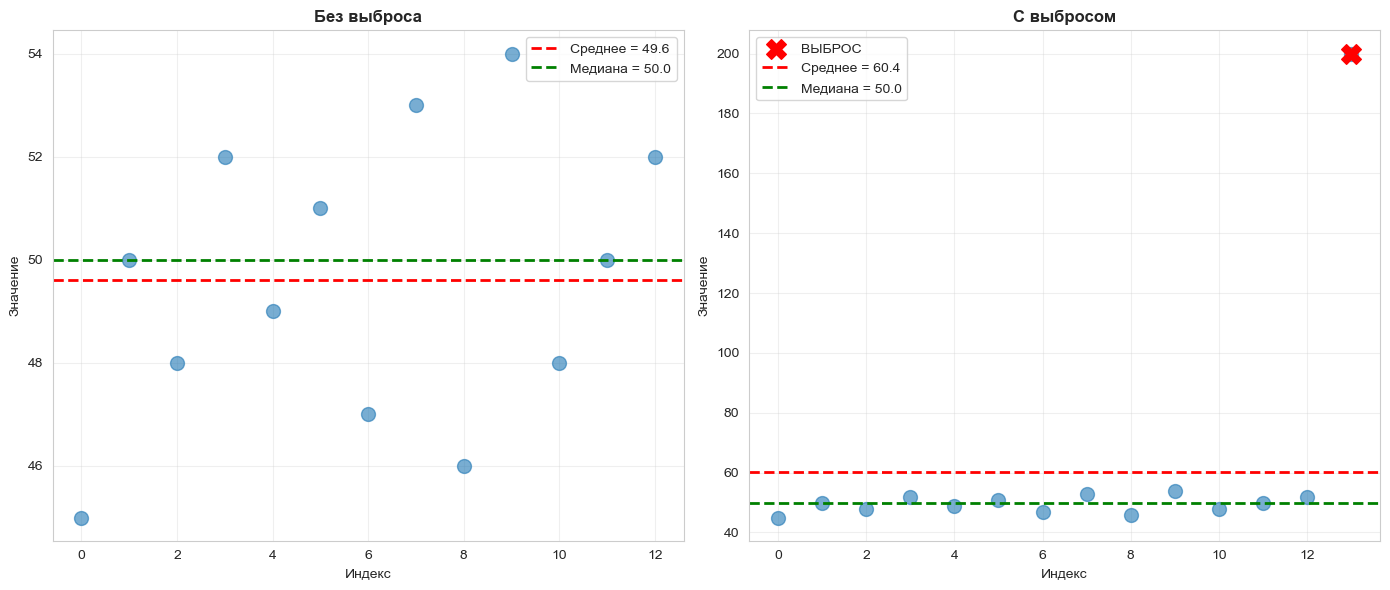

In [44]:
# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График 1: Без выброса
axes[0].scatter(range(len(normal_data)), normal_data, s=100, alpha=0.6)
axes[0].axhline(y=np.mean(normal_data), color='red', linestyle='--', 
                linewidth=2, label=f'Среднее = {np.mean(normal_data):.1f}')
axes[0].axhline(y=np.median(normal_data), color='green', linestyle='--', 
                linewidth=2, label=f'Медиана = {np.median(normal_data):.1f}')
axes[0].set_title('Без выброса', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Индекс')
axes[0].set_ylabel('Значение')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: С выбросом
axes[1].scatter(range(len(data_with_outlier)), data_with_outlier, s=100, alpha=0.6)
axes[1].scatter([len(data_with_outlier)-1], [200], s=200, color='red', 
                marker='X', zorder=5, label='ВЫБРОС')
axes[1].axhline(y=np.mean(data_with_outlier), color='red', linestyle='--', 
                linewidth=2, label=f'Среднее = {np.mean(data_with_outlier):.1f}')
axes[1].axhline(y=np.median(data_with_outlier), color='green', linestyle='--', 
                linewidth=2, label=f'Медиана = {np.median(data_with_outlier):.1f}')
axes[1].set_title('С выбросом', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Индекс')
axes[1].set_ylabel('Значение')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Методы выявления выбросов

Существует несколько методов для выявления выбросов. Рассмотрим основные:

1. **Визуальный метод** — анализ графиков
2. **Метод межквартильного размаха (IQR)** — основан на квартилях
3. **Метод Z-оценки (Z-score)** — основан на стандартных отклонениях
4. **Модифицированный Z-score** — робастная версия Z-score
5. **Методы машинного обучения**


## 4.1. Визуальный метод

Самый простой и часто самый эффективный метод — **посмотреть на данные!**

### Основные инструменты:
- **Boxplot** — показывает выбросы за пределами усов
- **Scatter plot** — выявляет точки, далекие от основной массы
- **Histogram** — показывает распределение и аномальные значения

ВИЗУАЛЬНЫЙ МЕТОД ВЫЯВЛЕНИЯ ВЫБРОСОВ

Сгенерировано 100 наблюдений
Основная масса данных: N(50, 10)
Добавлено 5 выбросов: [120, 10, 130, 5, 125]


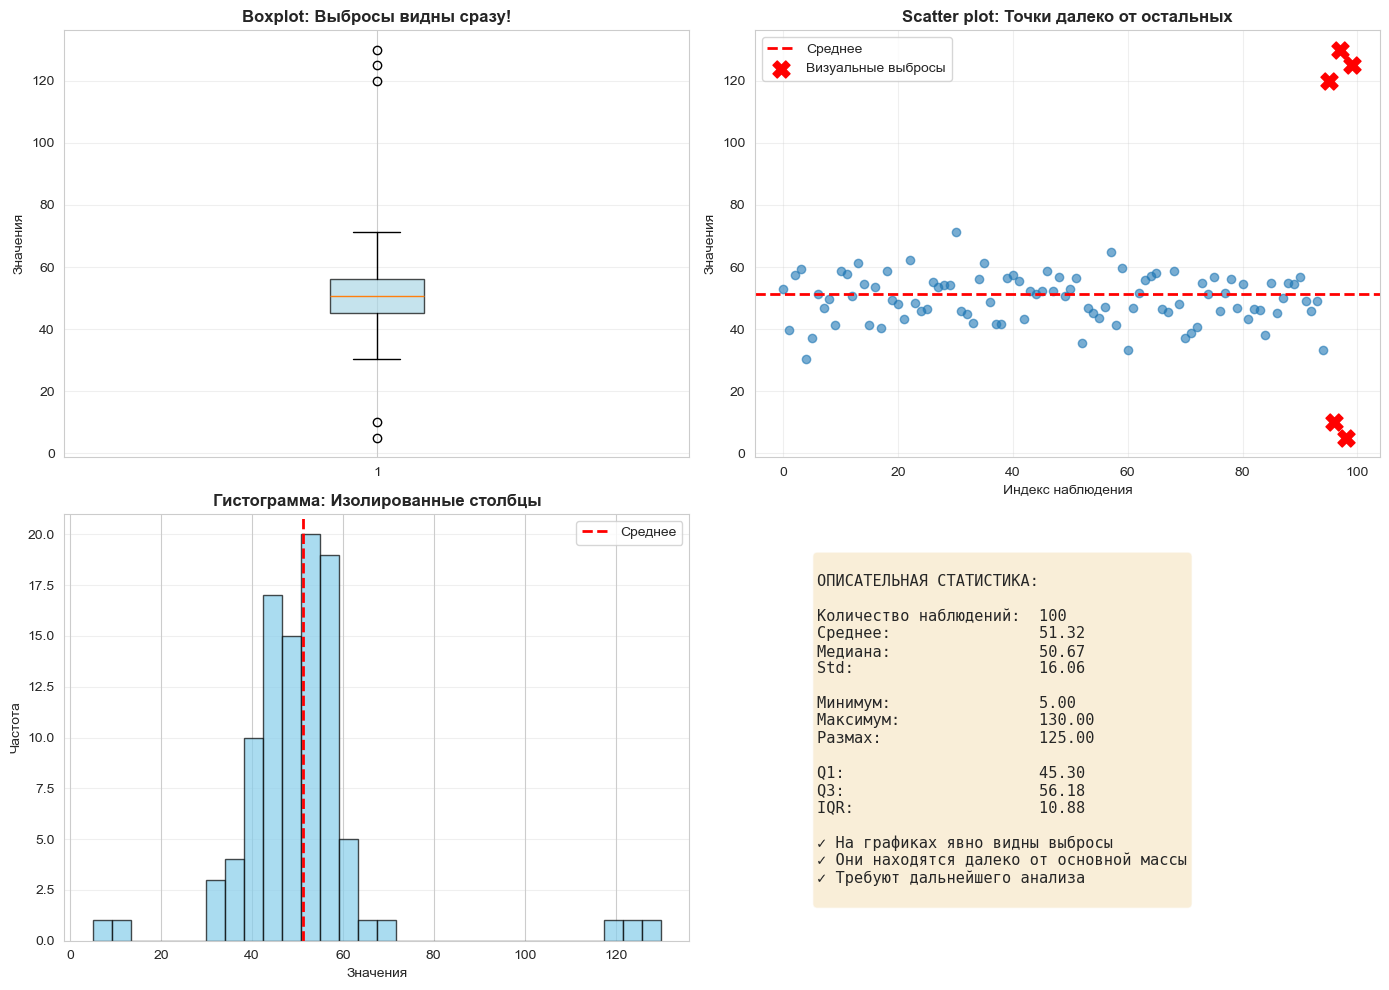

In [48]:
# Пример визуального анализа
rng = default_rng(42)

# Генерируем данные с несколькими выбросами
data_visual = np.concatenate([
    rng.normal(50, 10, 95),  # основная масса данных
    [120, 10, 130, 5, 125]  # выбросы
])

print("=" * 70)
print("ВИЗУАЛЬНЫЙ МЕТОД ВЫЯВЛЕНИЯ ВЫБРОСОВ")
print("=" * 70)
print(f"\nСгенерировано {len(data_visual)} наблюдений")
print(f"Основная масса данных: N(50, 10)")
print(f"Добавлено 5 выбросов: {[120, 10, 130, 5, 125]}")

# Создание графиков
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Boxplot
axes[0, 0].boxplot(data_visual, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[0, 0].set_title('Boxplot: Выбросы видны сразу!', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Значения')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Scatter plot
axes[0, 1].scatter(range(len(data_visual)), data_visual, alpha=0.6)
axes[0, 1].axhline(y=np.mean(data_visual), color='red', linestyle='--', 
                   linewidth=2, label='Среднее')
axes[0, 1].set_title('Scatter plot: Точки далеко от остальных', 
                     fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Индекс наблюдения')
axes[0, 1].set_ylabel('Значения')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Выделяем визуальные выбросы
outlier_threshold_upper = 80
outlier_threshold_lower = 20
visual_outliers = (data_visual > outlier_threshold_upper) | (data_visual < outlier_threshold_lower)
axes[0, 1].scatter(np.where(visual_outliers)[0], data_visual[visual_outliers], 
                   s=150, color='red', marker='X', zorder=5, label='Визуальные выбросы')
axes[0, 1].legend()

# 3. Histogram
axes[1, 0].hist(data_visual, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Гистограмма: Изолированные столбцы', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Значения')
axes[1, 0].set_ylabel('Частота')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].axvline(x=np.mean(data_visual), color='red', linestyle='--', 
                   linewidth=2, label='Среднее')
axes[1, 0].legend()

# 4. Описательная статистика
axes[1, 1].axis('off')
stats_text = f"""
ОПИСАТЕЛЬНАЯ СТАТИСТИКА:

Количество наблюдений:  {len(data_visual)}
Среднее:                {np.mean(data_visual):.2f}
Медиана:                {np.median(data_visual):.2f}
Std:                    {np.std(data_visual):.2f}

Минимум:                {np.min(data_visual):.2f}
Максимум:               {np.max(data_visual):.2f}
Размах:                 {np.max(data_visual) - np.min(data_visual):.2f}

Q1:                     {np.percentile(data_visual, 25):.2f}
Q3:                     {np.percentile(data_visual, 75):.2f}
IQR:                    {np.percentile(data_visual, 75) - np.percentile(data_visual, 25):.2f}

✓ На графиках явно видны выбросы
✓ Они находятся далеко от основной массы
✓ Требуют дальнейшего анализа
"""
axes[1, 1].text(0.1, 0.9, stats_text, fontsize=11, verticalalignment='top',
                family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


## 4.2. Метод межквартильного размаха (IQR Method)

**Метод IQR** — самый распространенный и надежный метод выявления выбросов.

### Формулы:

```
IQR = Q3 - Q1
Нижняя граница = Q1 - 1.5 × IQR
Верхняя граница = Q3 + 1.5 × IQR
```

### Интерпретация:
- Значения **ниже нижней границы** или **выше верхней границы** считаются выбросами

### Преимущества:
- ✅ Робастный метод (не зависит от выбросов)
- ✅ Основан на медиане, а не на среднем
- ✅ Работает с любым типом распределения
- ✅ Прост в вычислении и интерпретации

### Недостатки:
- ⚠️ Коэффициент 1.5 — это эмпирическое правило (можно изменить)
- ⚠️ Может быть слишком чувствительным для маленьких выборок

### 🔍 Пошаговый пример расчета IQR метода

In [50]:
# Пример данных: зарплаты сотрудников (в тысячах рублей)
salaries = np.array([45, 50, 48, 52, 49, 51, 47, 53, 200, 46, 54, 48, 50, 52])

print("=" * 70)
print("МЕТОД МЕЖКВАРТИЛЬНОГО РАЗМАХА (IQR)")
print("=" * 70)
print(f"\nИсходные данные (зарплаты в тыс. руб.):")
print(salaries)
print(f"Количество наблюдений: {len(salaries)}")

# ШАГ 1: Сортируем данные
sorted_data = np.sort(salaries)
print(f"\nШАГ 1: Отсортированные данные:")
print(sorted_data)

# ШАГ 2: Вычисляем квартили
Q1 = np.percentile(salaries, 25)
Q2 = np.percentile(salaries, 50)  # медиана
Q3 = np.percentile(salaries, 75)

print(f"\nШАГ 2: Вычисляем квартили:")
print(f"   Q1 (25-й процентиль): {Q1:.2f}")
print(f"   Q2 (50-й процентиль, медиана): {Q2:.2f}")
print(f"   Q3 (75-й процентиль): {Q3:.2f}")

# ШАГ 3: Вычисляем IQR
IQR = Q3 - Q1
print(f"\nШАГ 3: Вычисляем межквартильный размах:")
print(f"   IQR = Q3 - Q1 = {Q3:.2f} - {Q1:.2f} = {IQR:.2f}")
print(f"   → IQR показывает разброс средних 50% данных")

# ШАГ 4: Вычисляем границы
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nШАГ 4: Вычисляем границы для выбросов:")
print(f"   Нижняя граница = Q1 - 1.5×IQR = {Q1:.2f} - 1.5×{IQR:.2f} = {lower_bound:.2f}")
print(f"   Верхняя граница = Q3 + 1.5×IQR = {Q3:.2f} + 1.5×{IQR:.2f} = {upper_bound:.2f}")

# ШАГ 5: Выявляем выбросы
outliers_mask = (salaries < lower_bound) | (salaries > upper_bound)
outliers = salaries[outliers_mask]
outliers_indices = np.where(outliers_mask)[0]

print(f"\nШАГ 5: Выявляем выбросы:")
print(f"   Значения < {lower_bound:.2f} ИЛИ > {upper_bound:.2f}")
print(f"   Найдено выбросов: {len(outliers)}")
print(f"   Значения выбросов: {outliers}")
print(f"   Индексы выбросов: {outliers_indices}")

# ШАГ 6: Очищенные данные
clean_data = salaries[~outliers_mask]
print(f"\nШАГ 6: Очищенные данные (без выбросов):")
print(f"   {clean_data}")
print(f"   Количество: {len(clean_data)}")

print(f"\n📊 СРАВНЕНИЕ СТАТИСТИК:")
print(f"   {'Статистика':<20} {'С выбросами':<15} {'Без выбросов':<15} {'Разница':<10}")
print(f"   {'-'*60}")
print(f"   {'Среднее':<20} {np.mean(salaries):<15.2f} {np.mean(clean_data):<15.2f} {np.mean(salaries)-np.mean(clean_data):<10.2f}")
print(f"   {'Медиана':<20} {np.median(salaries):<15.2f} {np.median(clean_data):<15.2f} {np.median(salaries)-np.median(clean_data):<10.2f}")
print(f"   {'Std':<20} {np.std(salaries):<15.2f} {np.std(clean_data):<15.2f} {np.std(salaries)-np.std(clean_data):<10.2f}")

МЕТОД МЕЖКВАРТИЛЬНОГО РАЗМАХА (IQR)

Исходные данные (зарплаты в тыс. руб.):
[ 45  50  48  52  49  51  47  53 200  46  54  48  50  52]
Количество наблюдений: 14

ШАГ 1: Отсортированные данные:
[ 45  46  47  48  48  49  50  50  51  52  52  53  54 200]

ШАГ 2: Вычисляем квартили:
   Q1 (25-й процентиль): 48.00
   Q2 (50-й процентиль, медиана): 50.00
   Q3 (75-й процентиль): 52.00

ШАГ 3: Вычисляем межквартильный размах:
   IQR = Q3 - Q1 = 52.00 - 48.00 = 4.00
   → IQR показывает разброс средних 50% данных

ШАГ 4: Вычисляем границы для выбросов:
   Нижняя граница = Q1 - 1.5×IQR = 48.00 - 1.5×4.00 = 42.00
   Верхняя граница = Q3 + 1.5×IQR = 52.00 + 1.5×4.00 = 58.00

ШАГ 5: Выявляем выбросы:
   Значения < 42.00 ИЛИ > 58.00
   Найдено выбросов: 1
   Значения выбросов: [200]
   Индексы выбросов: [8]

ШАГ 6: Очищенные данные (без выбросов):
   [45 50 48 52 49 51 47 53 46 54 48 50 52]
   Количество: 13

📊 СРАВНЕНИЕ СТАТИСТИК:
   Статистика           С выбросами     Без выбросов    Разница   
  

### 📝 Функция для метода IQR

In [52]:
# Функция для выявления выбросов методом IQR
def detect_outliers_iqr(data, factor=1.5):
    """
    Выявление выбросов методом IQR
    
    Parameters:
    -----------
    data : array-like
        Массив данных
    factor : float, optional (default=1.5)
        Множитель для IQR (обычно 1.5 или 3)
    
    Returns:
    --------
    dict : словарь с результатами анализа
        - outliers: массив выбросов
        - outliers_indices: индексы выбросов
        - n_outliers: количество выбросов
        - lower_bound: нижняя граница
        - upper_bound: верхняя граница
        - clean_data: данные без выбросов
        - Q1, Q2, Q3, IQR: статистики
    """
    data = np.array(data)
    
    # Вычисление квартилей
    Q1 = np.percentile(data, 25)
    Q2 = np.percentile(data, 50)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    # Границы выбросов
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # Маска выбросов
    outliers_mask = (data < lower_bound) | (data > upper_bound)
    
    return {
        'outliers': data[outliers_mask],
        'outliers_indices': np.where(outliers_mask)[0],
        'n_outliers': np.sum(outliers_mask),
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'clean_data': data[~outliers_mask],
        'Q1': Q1,
        'Q2': Q2,
        'Q3': Q3,
        'IQR': IQR
    }

In [53]:
# Пример использования функции detect_outliers_iqr

result_iqr = detect_outliers_iqr(salaries)
print("\n" + "=" * 70)
print("РЕЗУЛЬТАТ РАБОТЫ ФУНКЦИИ detect_outliers_iqr()")
print("=" * 70)
print(f"Найдено выбросов: {result_iqr['n_outliers']}")
print(f"Выбросы: {result_iqr['outliers']}")
print(f"Границы: [{result_iqr['lower_bound']:.2f}, {result_iqr['upper_bound']:.2f}]")
print(f"IQR: {result_iqr['IQR']:.2f}")


РЕЗУЛЬТАТ РАБОТЫ ФУНКЦИИ detect_outliers_iqr()
Найдено выбросов: 1
Выбросы: [200]
Границы: [42.00, 58.00]
IQR: 4.00


## 4.3. Метод Z-оценки (Z-score Method)

**Z-score (Z-оценка)** — это статистический показатель, который измеряет, насколько далеко отдельное значение отстоит от среднего значения в распределении данных, выраженное в единицах стандартного отклонения. Он используется для выявления выбросов — точек данных, которые значительно отличаются от остальных.

---

### **Формула Z-score**
Для значения $x$ в наборе данных:
$$
z = \frac{x - \mu}{\sigma}
$$
где:
- $\mu$ — среднее арифметическое данных,
- $\sigma$ — стандартное отклонение.

---

### **Как работает метод?**
1. **Расчет Z-score**:
   - Вычисляются среднее значение и стандартное отклонение для всего набора данных.
   - Для каждой точки данных рассчитывается её Z-score.

2. **Пороговое значение**:
   - Если \(|z| > 3\), значение считается выбросом (реже используют \(|z| > 2.5\) или \(|z| > 2\)).
   - Например, при \(z = 3.5\) значение находится на расстоянии 3.5 стандартных отклонений от среднего, что встречается крайне редко в нормальном распределении (вероятность ~0.1%).

### Правило трех сигм:
- **68%** данных находятся в пределах ±1σ от среднего
- **95%** данных находятся в пределах ±2σ от среднего
- **99.7%** данных находятся в пределах ±3σ от среднего


### Преимущества:
- ✅ Простота вычисления
- ✅ Легко интерпретируется
- ✅ Показывает степень отклонения
- ✅ Эффективен для данных, близких к нормальному распределению

### Недостатки:
- ❌ Чувствительность к выбросам: само среднее и стандартное отклонение могут искажаться из-за выбросов.
- ❌ Требует нормального распределения
- ❌ Не подходит для асимметричных данных
- ❌ Не учитывает структуру данных (например, временные ряды).

### 🔍 Пошаговый пример расчета Z-score

In [61]:
# Пример использования метода Z-score для выявления выбросов
print("=" * 50)
print("ОБНАРУЖЕНИЕ ВЫБРОСОВ: МЕТОД Z-SCORE")
print("=" * 50)

# Зарплаты сотрудников (в тысячах рублей)
salaries = np.array([45, 50, 48, 52, 49, 51, 47, 53, 200, 46, 54, 48, 50, 52])

print(f"Исходные данные (зарплаты в тыс. руб.):")
print(f"Количество сотрудников: {len(salaries)}")
print(f"Зарплаты: {salaries}")

# Автоматический расчет Z-score
z_scores = stats.zscore(salaries, ddof=1)

# Альтернативно, можно использовать формулу вручную:
# mean = np.mean(salaries)
# std = np.std(salaries, ddof=1)
# z_scores = (salaries - mean) / std

print(f"\n📊 ОСНОВНЫЕ СТАТИСТИКИ:")
print(f"   Среднее: {np.mean(salaries):.1f} тыс. руб.")
print(f"   Стандартное отклонение: {np.std(salaries, ddof=1):.1f} тыс. руб.")

print(f"\n🔍 АНАЛИЗ Z-SCORE (автоматический расчет):")
print(f"{'Зарплата':<10} {'Z-score':<10} {'Статус':<20}")
print("-" * 40)

for salary, z in zip(salaries, z_scores):
    if abs(z) > 3:
        status = "ВЫБРОС (|Z| > 3)"
        emoji = "🔴"
    elif abs(z) > 2:
        status = "Подозрительно (|Z| > 2)"
        emoji = "🟡"
    else:
        status = "Норма"
        emoji = "🟢"
    
    print(f"{salary:<10} {z:<+10.2f} {emoji} {status}")

# Выявляем выбросы
threshold = 3
outliers_mask = np.abs(z_scores) > threshold
outliers = salaries[outliers_mask]
outliers_indices = np.where(outliers_mask)[0]

print(f"\n📈 РЕЗУЛЬТАТЫ:")
print(f"   Обнаружено выбросов: {len(outliers)}")
print(f"   Выбросы: {outliers} тыс. руб.")
print(f"   Индексы выбросов: {outliers_indices}")

# Дополнительная информация
print(f"\n💡 ИНТЕРПРЕТАЦИЯ:")
print(f"   • {len(outliers)} зарплат значительно отличаются от среднего")
print(f"   • Выбросы составляют {len(outliers)/len(salaries)*100:.1f}% от всех данных")
if len(outliers) > 0:
    print(f"   • Без выбросов средняя зарплата: {np.mean(salaries[~outliers_mask]):.1f} тыс. руб.")

ОБНАРУЖЕНИЕ ВЫБРОСОВ: МЕТОД Z-SCORE
Исходные данные (зарплаты в тыс. руб.):
Количество сотрудников: 14
Зарплаты: [ 45  50  48  52  49  51  47  53 200  46  54  48  50  52]

📊 ОСНОВНЫЕ СТАТИСТИКИ:
   Среднее: 60.4 тыс. руб.
   Стандартное отклонение: 40.3 тыс. руб.

🔍 АНАЛИЗ Z-SCORE (автоматический расчет):
Зарплата   Z-score    Статус              
----------------------------------------
45         -0.38      🟢 Норма
50         -0.26      🟢 Норма
48         -0.31      🟢 Норма
52         -0.21      🟢 Норма
49         -0.28      🟢 Норма
51         -0.23      🟢 Норма
47         -0.33      🟢 Норма
53         -0.18      🟢 Норма
200        +3.47      🔴 ВЫБРОС (|Z| > 3)
46         -0.36      🟢 Норма
54         -0.16      🟢 Норма
48         -0.31      🟢 Норма
50         -0.26      🟢 Норма
52         -0.21      🟢 Норма

📈 РЕЗУЛЬТАТЫ:
   Обнаружено выбросов: 1
   Выбросы: [200] тыс. руб.
   Индексы выбросов: [8]

💡 ИНТЕРПРЕТАЦИЯ:
   • 1 зарплат значительно отличаются от среднего
   • Выбросы сос

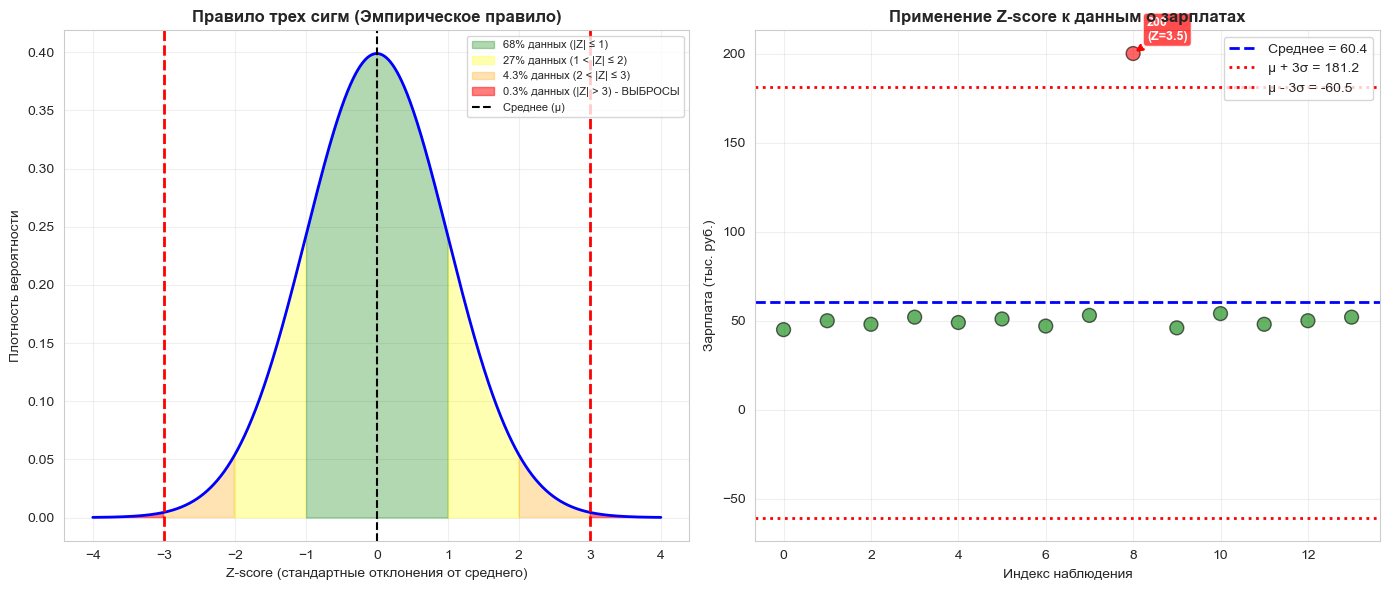

In [57]:
# Визуализация стандартного нормального распределения с зонами
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График 1: Нормальное распределение с зонами
x_norm = np.linspace(-4, 4, 1000)
y_norm = stats.norm.pdf(x_norm, 0, 1)

axes[0].plot(x_norm, y_norm, 'b-', linewidth=2)
axes[0].fill_between(x_norm, y_norm, where=(np.abs(x_norm) <= 1), 
                     alpha=0.3, color='green', label='68% данных (|Z| ≤ 1)')
axes[0].fill_between(x_norm, y_norm, where=(np.abs(x_norm) <= 2) & (np.abs(x_norm) > 1), 
                     alpha=0.3, color='yellow', label='27% данных (1 < |Z| ≤ 2)')
axes[0].fill_between(x_norm, y_norm, where=(np.abs(x_norm) <= 3) & (np.abs(x_norm) > 2), 
                     alpha=0.3, color='orange', label='4.3% данных (2 < |Z| ≤ 3)')
axes[0].fill_between(x_norm, y_norm, where=(np.abs(x_norm) > 3), 
                     alpha=0.5, color='red', label='0.3% данных (|Z| > 3) - ВЫБРОСЫ')

axes[0].axvline(0, color='black', linestyle='--', label='Среднее (μ)')
axes[0].axvline(-3, color='red', linestyle='--', linewidth=2)
axes[0].axvline(3, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Z-score (стандартные отклонения от среднего)')
axes[0].set_ylabel('Плотность вероятности')
axes[0].set_title('Правило трех сигм (Эмпирическое правило)', fontweight='bold')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# График 2: Наши данные с Z-score
colors = ['red' if abs(z) > 3 else 'orange' if abs(z) > 2 else 'green' 
          for z in z_scores]

axes[1].scatter(range(len(salaries)), salaries, c=colors, s=100, alpha=0.6, edgecolors='black')
axes[1].axhline(y=mean, color='blue', linestyle='--', label=f'Среднее = {mean:.1f}', linewidth=2)
axes[1].axhline(y=mean + 3*std, color='red', linestyle=':', 
               label=f'μ + 3σ = {mean + 3*std:.1f}', linewidth=2)
axes[1].axhline(y=mean - 3*std, color='red', linestyle=':', 
               label=f'μ - 3σ = {mean - 3*std:.1f}', linewidth=2)

# Аннотации для выбросов
for i, (val, z) in enumerate(zip(salaries, z_scores)):
    if abs(z) > 3:
        axes[1].annotate(f'{val}\n(Z={z:.1f})', xy=(i, val), 
                       xytext=(10, 10), textcoords='offset points',
                       bbox=dict(boxstyle='round', facecolor='red', alpha=0.7),
                       fontsize=9, color='white', fontweight='bold',
                       arrowprops=dict(arrowstyle='->', color='red', lw=2))

axes[1].set_xlabel('Индекс наблюдения')
axes[1].set_ylabel('Зарплата (тыс. руб.)')
axes[1].set_title('Применение Z-score к данным о зарплатах', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 📝 Функция для метода Z-score

In [62]:
# Функция для выявления выбросов методом Z-score
def detect_outliers_zscore(data, threshold=3):
    """
    Выявление выбросов методом Z-score
    
    Parameters:
    -----------
    data : array-like
        Массив данных
    threshold : float, optional (default=3)
        Пороговое значение |Z| для выбросов
    
    Returns:
    --------
    dict : словарь с результатами анализа
    """
    data = np.array(data)
    
    # Вычисление Z-scores
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    z_scores = (data - mean) / std
    
    # Маска выбросов
    outliers_mask = np.abs(z_scores) > threshold
    
    return {
        'outliers': data[outliers_mask],
        'outliers_indices': np.where(outliers_mask)[0],
        'n_outliers': np.sum(outliers_mask),
        'z_scores': z_scores,
        'mean': mean,
        'std': std,
        'threshold': threshold,
        'clean_data': data[~outliers_mask]
    }

In [63]:
# Пример использования функции detect_outliers_zscore
result_zscore = detect_outliers_zscore(salaries)
print("\n" + "=" * 70)
print("РЕЗУЛЬТАТ РАБОТЫ ФУНКЦИИ detect_outliers_zscore()")
print("=" * 70)
print(f"Найдено выбросов: {result_zscore['n_outliers']}")
print(f"Выбросы: {result_zscore['outliers']}")
print(f"Среднее: {result_zscore['mean']:.2f}")
print(f"Std: {result_zscore['std']:.2f}")


РЕЗУЛЬТАТ РАБОТЫ ФУНКЦИИ detect_outliers_zscore()
Найдено выбросов: 1
Выбросы: [200]
Среднее: 60.36
Std: 40.28


# 5. Сравнение методов

| Характеристика             | IQR Method        | Z-score Method    |
|----------------------------|-------------------|-------------------|
| **Основан на**             | Квартилях (Q1,Q3) | Среднем и Ст.Откл.     |
| **Мера центра**            | Медиана           | Среднее           |
| **Мера разброса**          | IQR               | Std               |
| **Робастность**            | Высокая ✓         | Низкая ✗          |
| **Чувствителен к выбросам**| Нет ✓             | Да ✗              |
| **Требует нормальность**   | Нет ✓             | Да ✗              |
| **Работает с асимметричными** | Да ✓           | Плохо ✗           |
| **Простота вычисления**    | Простой           | Простой           |
| **Популярность**           | Очень высокая     | Высокая           |
| **Лучше для**              | Асимметричных данных, небольших выборок | Нормальных распределений, больших выборок |
| **Пороговые значения**     | Q1 - 1.5×IQR, Q3 + 1.5×IQR | Обычно \|Z\| > 2 или 3 |
| **Многомерные данные**     | Сложно применить  | Легко применить   |

# 6. Практические рекомендации

## 🎯 РЕКОМЕНДАЦИИ ПО ВЫБОРУ МЕТОДА

### Общий алгоритм принятия решений

### 1️⃣ НАЧНИТЕ С ВИЗУАЛИЗАЦИИ

**Всегда стройте графики перед применением методов!**

#### Обязательные визуализации:
- **Boxplot** — показывает выбросы за пределами усов
- **Histogram** — показывает форму распределения и асимметрию
- **Scatter plot** — выявляет точки, далекие от основной массы

#### Что искать:
- Очевидные выбросы, далекие от остальных данных
- Форму распределения (симметричное/асимметричное)
- Кластеры и группы в данных
- Тренды и закономерности

### 2️⃣ ОПРЕДЕЛИТЕ ТИП РАСПРЕДЕЛЕНИЯ

**Вычислите коэффициент асимметрии (skewness):**

#### Интерпретация Skewness:

| Значение | Тип распределения | Рекомендуемый метод |
|----------|-------------------|---------------------|
| **\|Skew\| < 0.5** | Симметричное | ✅ Z-score или IQR |
| **0.5 ≤ Skew < 1** | Умеренная правая асимметрия | ⚠️ IQR (предпочтительно) |
| **Skew ≥ 1** | Сильная правая асимметрия | ✅ IQR или Modified Z-score |
| **-1 < Skew ≤ -0.5** | Умеренная левая асимметрия | ⚠️ IQR (предпочтительно) |
| **Skew ≤ -1** | Сильная левая асимметрия | ✅ IQR или Modified Z-score |

---

### 3️⃣ ВЫБЕРИТЕ МЕТОД НА ОСНОВЕ ХАРАКТЕРИСТИК ДАННЫХ

#### 📊 Симметричное распределение (|Skewness| ≈ 0)

**Характеристики:**
- Среднее ≈ Медиана ≈ Мода
- Данные равномерно распределены вокруг центра
- Колоколообразная форма

**Рекомендации:**
- ✅ **Z-score** — хороший выбор (требует нормальности)
- ✅ **IQR** — тоже отлично работает (более робастный)
- ✅ **Modified Z-score** — можно использовать

**Примеры данных:**
- Рост взрослых людей
- Показатели IQ
- Случайные ошибки измерений

---

#### 📈 Правостороннее асимметричное распределение (Skewness > 0)

**Характеристики:**
- Среднее > Медиана
- Длинный "хвост" справа
- Большинство значений слева

**Рекомендации:**
- ✅ **IQR** — ЛУЧШИЙ выбор (робастен к асимметрии)
- ✅ **Modified Z-score** — хорошая альтернатива
- ❌ **Z-score** — НЕ рекомендуется (среднее искажено выбросами)

**Примеры данных:**
- Доходы населения 💰
- Цены на недвижимость 🏠
- Время отклика веб-сервера ⏱️
- Размер файлов 💾

**Почему Z-score не подходит:**
- Среднее сильно смещено вправо из-за выбросов
- Стандартное отклонение завышено
- Границы выявления выбросов некорректны

---

#### 📉 Левостороннее асимметричное распределение (Skewness < 0)

**Характеристики:**
- Среднее < Медиана
- Длинный "хвост" слева
- Большинство значений справа

**Рекомендации:**
- ✅ **IQR** — ЛУЧШИЙ выбор
- ✅ **Modified Z-score** — хорошая альтернатива
- ❌ **Z-score** — НЕ рекомендуется

**Примеры данных:**
- Оценки на экзаменах 📝
- Возраст смерти в развитых странах
- Уровень удовлетворенности (шкала 1-10)
- Процент выполнения плана

---

### 4️⃣ ИСПОЛЬЗУЙТЕ НЕСКОЛЬКО МЕТОДОВ

**Принцип:**
- Выбросы, найденные **всеми методами** — самые подозрительные
- Выбросы, найденные **одним методом** — требуют дополнительного анализа
- Сравните количество выбросов по методам

---

### 5️⃣ СПЕЦИАЛЬНЫЕ СЛУЧАИ

#### Малая выборка (n < 30)

**Проблема:** Статистики нестабильны при малых выборках

**Решение:**
- ✅ Используйте **IQR** (наиболее робастный)
- ⚠️ Будьте осторожны с Z-score
- 📊 Обязательная визуализация
- 🔍 Ручная проверка каждого потенциального выброса

#### Мультимодальное распределение

**Проблема:** Несколько пиков в данных (несколько групп)

**Решение:**
- 🔬 Разделите данные на группы
- 📊 Анализируйте каждую группу отдельно
- 🚫 Не применяйте методы к объединенным данным


---

## 💡 СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТОДОВ

| Критерий | IQR | Z-score | Modified Z-score |
|----------|-----|---------|------------------|
| **Основа** | Квартили (Q1, Q3) | Среднее и σ | Медиана и MAD |
| **Мера центра** | Медиана | Среднее | Медиана |
| **Мера разброса** | IQR | Std | MAD |
| **Робастность** | ✅ Высокая | ❌ Низкая | ✅ Высокая |
| **Чувствителен к выбросам** | ❌ Нет | ✅ Да | ❌ Нет |
| **Требует нормальность** | ❌ Нет | ✅ Да | ❌ Нет |
| **Симметричные данные** | ✅ Хорошо | ✅ Отлично | ✅ Хорошо |
| **Асимметричные данные** | ✅ Отлично | ❌ Плохо | ✅ Отлично |
| **Простота** | ⭐⭐⭐ Очень простой | ⭐⭐⭐ Очень простой | ⭐⭐ Средний |
| **Популярность** | ⭐⭐⭐ Очень высокая | ⭐⭐⭐ Высокая | ⭐⭐ Средняя |
| **Интерпретация** | Интуитивная | Интуитивная | Требует пояснений |

### Итоговые рекомендации:

**🥇 Для большинства случаев: IQR**
- Робастный, универсальный, простой
- Работает с любым типом распределения

**🥈 Для нормальных данных: Z-score**
- Если уверены в нормальности распределения
- Хорошо интерпретируется

**🥉 Для асимметричных данных: Modified Z-score**
- Альтернатива IQR с другим пороговым значением
- Более формальный подход

---



## 🔧 ЧТО ДЕЛАТЬ С ВЫБРОСАМИ?

### Общий принцип

> **⚠️ НЕ УДАЛЯЙТЕ ВЫБРОСЫ АВТОМАТИЧЕСКИ!**
> 
> Каждый выброс требует индивидуального анализа и обоснованного решения.

---

### Алгоритм принятия решений

```
┌──────────────────────────────┐
│   Выброс обнаружен           │
└──────────┬───────────────────┘
           ↓
┌──────────────────────────────┐
│ 1. Проверьте на ошибку ввода │
└──────────┬───────────────────┘
           ↓
      ┌────┴────┐
      │ Ошибка? │
      └────┬────┘
           │
    ┌──────┼──────┐
    ↓              ↓
   ДА             НЕТ
    │              │
    ↓              ↓
┌────────┐    ┌────────────────┐
│Исправь-│    │ 2. Можно ли    │
│те или  │    │    исправить?  │
│удалите │    └───────┬────────┘
└────────┘            │
                ┌─────┼─────┐
                ↓           ↓
               ДА          НЕТ
                │           │
                ↓           ↓
          ┌──────────┐  ┌──────────────┐
          │Исправьте │  │ 3. Содержит  │
          │          │  │ информацию?  │
          └──────────┘  └──────┬───────┘
                              │
                        ┌─────┼─────┐
                        ↓           ↓
                       ДА          НЕТ
                        │           │
                        ↓           ↓
                  ┌──────────┐ ┌────────┐
                  │ ОСТАВЬТЕ │ │УДАЛИТЕ │
                  │          │ │с докум.│
                  └──────────┘ └────────┘
```

---

### 1. ✅ ОСТАВИТЬ ВЫБРОС

#### Когда оставлять:

**✓ Это реальное, корректно измеренное значение**
- Значение подтверждено независимыми источниками
- Есть объяснение, почему значение такое экстремальное
- Повторные измерения дают тот же результат

**✓ Выброс содержит важную информацию**
- Представляет редкое, но важное событие
- Цель анализа — именно найти такие аномалии
- Отражает реальную вариабельность процесса

**✓ Выброс имеет бизнес-значение**
- VIP-клиенты с высокими покупками
- Критические инциденты в системе
- Успешные кейсы для изучения

#### Примеры:

**Обнаружение мошенничества** 🚨
```
Транзакции: [100, 150, 200, 120, 50000, 180, ...]
                                  ↑
                           Подозрительная транзакция
→ ОСТАВИТЬ! Это именно то, что мы ищем
```

**Мониторинг оборудования** ⚙️
```
Температура сервера: [45°, 47°, 46°, 95°, 48°, ...]
                                      ↑
                              Перегрев!
→ ОСТАВИТЬ! Критическая информация о проблеме
```

**Анализ продаж** 💰
```
Продажи менеджеров: [50k, 60k, 55k, 200k, 58k, ...]
                                       ↑
                             Звезда продаж
→ ОСТАВИТЬ! Изучить его методы
```

---

### 2. 🔧 ИСПРАВИТЬ ВЫБРОС

#### Когда исправлять:

**✓ Ошибка ввода данных (опечатка)**
- Очевидная опечатка в цифрах
- Неправильная единица измерения
- Лишний ноль или точка

**✓ Технический сбой**
- Ошибка сенсора или прибора
- Сбой в системе сбора данных
- Проблема синхронизации

**✓ Можно восстановить правильное значение**
- Есть дубликат записи с правильным значением
- Можно интерполировать из соседних измерений
- Есть документация с правильным значением

#### Примеры исправлений:

**Ошибка единиц измерения** 📏
```python
# Было: рост 1800 см вместо 180 см
data.loc[data['height'] > 300, 'height'] = data.loc[data['height'] > 300, 'height'] / 10
```

**Лишний ноль** 🔢
```python
# Было: возраст 990 лет вместо 99
data.loc[data['age'] == 990, 'age'] = 99
```

**Неправильный знак** ➖➕
```python
# Было: температура -25° летом вместо +25°
data.loc[(data['month'] == 7) & (data['temp'] < 0), 'temp'] *= -1
```

**Интерполяция для временных рядов** 📈
```python
# Явно ошибочное значение в середине
data.loc[100, 'value'] = np.nan
data['value'] = data['value'].interpolate(method='linear')
```

---

### 3. ❌ УДАЛИТЬ ВЫБРОС

#### Когда удалять:

**✓ Точно известно, что это ошибка**
- Физически невозможное значение
- Противоречит законам природы/бизнеса
- Подтверждено как ошибка, но невозможно исправить

**✓ Выброс не относится к изучаемой популяции**
- Данные из другой категории попали в выборку
- Тестовые записи в продакшн-данных
- Данные из переходного периода

**✓ Выброс искажает анализ без добавления ценности**
- Единичная ошибка портит всю модель
- Не несет информации о процессе
- Технический артефакт

#### ⚠️ КРИТИЧЕСКИ ВАЖНО: ДОКУМЕНТИРУЙТЕ УДАЛЕНИЕ!

**Что записать:**
1. Сколько выбросов удалено
2. Какие именно значения
3. Почему удалено (обоснование)
4. Когда удалено (дата)
5. Кто принял решение
6. Как это повлияло на результаты

```python
# Пример документирования
removed_outliers = {
    'date': '2024-01-15',
    'analyst': 'Иванов И.И.',
    'reason': 'Физически невозможные значения (отрицательные цены)',
    'count': 5,
    'values': [-100, -50, -200, -75, -150],
    'indices': [123, 456, 789, 1011, 1213],
    'impact': {
        'mean_before': 1000.5,
        'mean_after': 995.2,
        'std_before': 350.0,
        'std_after': 150.0
    }
}

# Сохранение в файл
import json
with open('outliers_removed_log.json', 'w') as f:
    json.dump(removed_outliers, f, indent=4)
```

#### Примеры физически невозможных значений:

```python
# Возраст не может быть отрицательным или больше 150
data = data[(data['age'] >= 0) & (data['age'] <= 150)]

# Процент не может быть вне диапазона 0-100
data = data[(data['percentage'] >= 0) & (data['percentage'] <= 100)]

# Цена не может быть отрицательной
data = data[data['price'] >= 0]

# Дата не может быть в будущем
from datetime import datetime
data = data[data['date'] <= datetime.now()]
```

---

### 4. 🔄 ТРАНСФОРМИРОВАТЬ ДАННЫЕ

#### Когда применять трансформацию:

**✓ Распределение сильно асимметрично**
- Множество выбросов с одной стороны
- Skewness > 1 или < -1
- Выбросы — естественная часть распределения

**✓ Нужно применить методы, требующие нормальности**
- Параметрические статистические тесты
- Линейная регрессия
- ANOVA

**✓ Выбросы невозможно удалить**
- Все значения корректны
- Отражают реальную вариабельность

#### Методы трансформации:

##### Логарифмическая трансформация (для правосторонней асимметрии)

```python
import numpy as np

# Применение log-трансформации
data_log = np.log(data)  # натуральный логарифм
# или
data_log = np.log10(data)  # десятичный логарифм

# ⚠️ Важно: данные должны быть > 0
# Если есть нули, добавьте константу:
data_log = np.log(data + 1)
```

**Когда использовать:**
- Доходы, цены, размеры файлов
- Время выполнения задач
- Численность населения городов

**Пример:**
```python
# До трансформации
income = [20000, 25000, 30000, 35000, 500000]  # сильный выброс
skewness_before = stats.skew(income)  # 2.24 (сильная асимметрия)

# После трансформации
income_log = np.log(income)
skewness_after = stats.skew(income_log)  # 0.12 (почти симметрично!)
```

##### Квадратный корень (для умеренной правосторонней асимметрии)

```python
data_sqrt = np.sqrt(data)
```

**Когда использовать:**
- Данные подсчетов (counts)
- Менее агрессивная, чем логарифм

##### Box-Cox трансформация (автоматический подбор)

```python
from scipy.stats import boxcox

# Автоматический подбор оптимального преобразования
data_transformed, lambda_param = boxcox(data)

print(f"Оптимальный параметр λ: {lambda_param:.3f}")
# λ = 1: нет трансформации
# λ = 0: log-трансформация
# λ = 0.5: sqrt-трансформация
```

##### Обратная трансформация (для левосторонней асимметрии)

```python
# Отражение + логарифм
max_value = data.max()
data_reflected = max_value - data
data_transformed = np.log(data_reflected + 1)
```

#### Визуализация эффекта трансформации:

```python
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# До трансформации
axes[0, 0].hist(data, bins=30)
axes[0, 0].set_title(f'До: Skewness = {stats.skew(data):.2f}')

axes[0, 1].boxplot(data)
axes[0, 1].set_title('Boxplot до')

# После трансформации
axes[1, 0].hist(data_log, bins=30)
axes[1, 0].set_title(f'После: Skewness = {stats.skew(data_log):.2f}')

axes[1, 1].boxplot(data_log)
axes[1, 1].set_title('Boxplot после')

plt.tight_layout()
plt.show()
```

---

### 5. 📊 ИСПОЛЬЗОВАТЬ РОБАСТНЫЕ МЕТОДЫ

#### Когда применять:

**✓ Выбросы нельзя удалить**
- Все значения корректны и важны
- Выбросы — часть естественной вариабельности

**✓ Нужна устойчивость к выбросам**
- Автоматизированные системы
- Данные в реальном времени
- Критические приложения

#### Робастные альтернативы:

##### Меры центральной тенденции:

```python
# Вместо среднего → медиана
central = np.median(data)  # устойчива к выбросам

# Усеченное среднее (trimmed mean)
from scipy.stats import trim_mean
central = trim_mean(data, proportiontocut=0.1)  # отбрасываем 10% с каждой стороны

# Винсоризированное среднее (winsorized mean)
from scipy.stats.mstats import winsorize
data_winsorized = winsorize(data, limits=[0.05, 0.05])  # заменяем 5% экстремумов
central = np.mean(data_winsorized)
```

##### Меры разброса:

```python
# Вместо стандартного отклонения → MAD
from scipy.stats import median_abs_deviation
spread = median_abs_deviation(data)  # устойчиво к выбросам

# IQR
spread = np.percentile(data, 75) - np.percentile(data, 25)
```

##### Робастная регрессия:

```python
from sklearn.linear_model import HuberRegressor, RANSACRegressor

# Вместо обычной линейной регрессии
model = HuberRegressor()  # устойчива к выбросам
model.fit(X, y)
```

##### Робастное масштабирование:

```python
from sklearn.preprocessing import RobustScaler

# Вместо StandardScaler (основан на среднем и std)
scaler = RobustScaler()  # основан на медиане и IQR
X_scaled = scaler.fit_transform(X)
```

---

## 📋 ЧЕКЛИСТ РАБОТЫ С ВЫБРОСАМИ

### Перед анализом:

- [ ] Визуализировал данные (boxplot, histogram, scatter)
- [ ] Вычислил описательную статистику
- [ ] Определил тип распределения (skewness)
- [ ] Выбрал подходящий метод выявления

### Выявление выбросов:

- [ ] Применил 2-3 метода для сравнения
- [ ] Задокументировал найденные выбросы
- [ ] Определил выбросы-консенсус (найденные всеми методами)
- [ ] Визуально проверил найденные выбросы

### Анализ выбросов:

- [ ] Проверил на ошибки ввода данных
- [ ] Оценил физическую/логическую возможность значений
- [ ] Понял возможные причины аномалий
- [ ] Определил, несут ли выбросы информацию

### Принятие решения:

- [ ] Принял обоснованное решение (оставить/исправить/удалить)
- [ ] Задокументировал решение и обоснование
- [ ] Зафиксировал влияние на статистики (до/после)
- [ ] Создал резервную копию данных перед изменениями

### После обработки:

- [ ] Проверил результаты на разумность
- [ ] Пересчитал описательную статистику
- [ ] Создал отчет о проделанной работе
- [ ] Сохранил код и документацию

---

## 🎯 ПРАКТИЧЕСКИЕ СОВЕТЫ

### ✅ DO (Делайте):

1. **Всегда начинайте с визуализации**
   - Графики дают интуитивное понимание данных
   - Выявляют паттерны, которые статистика может пропустить

2. **Используйте domain knowledge**
   - Привлекайте экспертов предметной области
   - Понимайте контекст и природу данных

3. **Документируйте все действия**
   - Создавайте воспроизводимый анализ
   - Записывайте обоснования решений

4. **Сохраняйте оригинальные данные**
   - Всегда работайте с копией
   - Можно вернуться к исходным данным

5. **Проверяйте влияние на результаты**
   - Сравнивайте статистики до/после
   - Оценивайте влияние на модели

### ❌ DON'T (Не делайте):

1. **Не удаляйте выбросы автоматически**
   - Каждый выброс требует анализа
   - Автоматическое удаление может уничтожить важную информацию

2. **Не используйте только один метод**
   - Разные методы могут дать разные результаты
   - Консенсус методов — более надежен

3. **Не игнорируйте контекст**
   - То, что статистически аномально, может быть нормой для процесса
   - Учитывайте специфику данных

4. **Не применяйте Z-score к асимметричным данным**
   - Это приведет к неправильным выводам
   - Используйте робастные методы

5. **Не забывайте о бизнес-логике**
   - Статистика должна служить бизнесу, а не наоборот
   - Некоторые "выбросы" могут быть ключевыми инсайтами
